# Set-up

In [1]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import seaborn as sns
import numpy as np
import random
import pickle

sns.set_theme()
colors = sns.color_palette("deep")

from NMF_iter import functional_norm, normalize_curves
from scipy.stats import levene
from utils import plot_components

from itertools import permutations

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

'it_IT'

In [2]:
# region_order = [
#     'North',
#     'Centre.North',
#     'Sardinia',
#     'Centre.South',
#     'South',
#     'Calabria',
#     'Sicily'
# ]

region_order = [
    'Italy'
]

daytype_order = [
    'Monday',
    'Working day',
    'Saturday',
    'Holiday'
]

train_years = [2020, 2021, 2022]
test_years = [2023]

# Load selected model and input data

In [3]:
smoothed = False
n_comp = 5
n_runs = 1000
alpha = '3e-10'
specific = '_Italy'

method = f"{n_comp}comp{smoothed*'_smoothed'}_{n_runs}runs_PenNMF_lambda_{alpha}"
data = np.load('data/3_output/nmf_results/' + 'WHopt_' + method + '.npz', allow_pickle=True)
with open('data/3_output/nmf_results/' + 'PenNMF_' + method + '.pkl', 'rb') as file:
    model = pickle.load(file)

W_train = data['W']
H = data['H']

In [4]:
# HOTFIX: reordering components for plotting
# reordering = np.array([2, 1, 0])
# W = W[:, reordering]
# H = H[reordering, :]

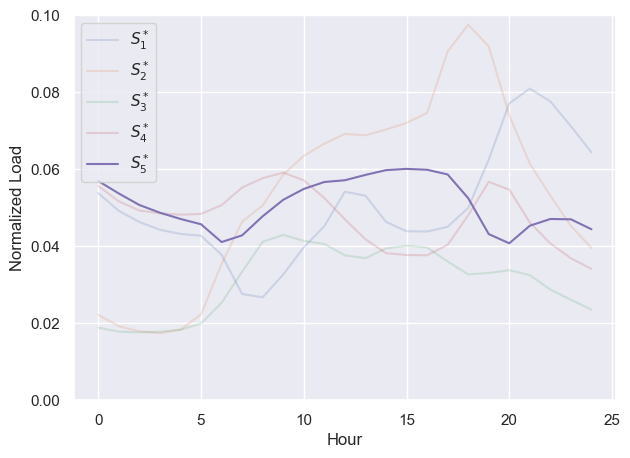

In [5]:
fig, ax = plot_components(H, labels=[f'$S_{i+1}^*$' for i in range(n_comp)], marker=None, linewidth=1.5, figsize=(7, 5), emphasize_comp=5)
left, right = ax.set_ylim((0,0.1))

In [6]:
input_df = pd.read_csv(f"data/2_processed/daily_curves{specific}{'_smoothed_15min'*smoothed}.csv", index_col=0)
# Convert everything in GWh
input_df = input_df / 1000
pattern = r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$'
unit_info = input_df.index.str.extract(pattern).set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
select_period_train = df.year.astype(int).isin(train_years)
select_period_test = df.year.astype(int).isin(test_years)
df = df.loc[select_period_train | select_period_test, :]
unit_info = unit_info.loc[select_period_train | select_period_test, :]
unit_info_train = unit_info.loc[select_period_train, :]
unit_info_test = unit_info.loc[select_period_test, :]
df_train = df.loc[select_period_train, :]
df_test = df.loc[select_period_test, :]
print(len(df_train))
df_train.head(3)

1096


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Italy_2020-01-01_Holiday,24.300000,23.308000,22.157999,20.786000,19.891000,19.947001,20.578999,21.473999,21.413001,22.792,...,30.459000,30.347000,29.180,27.406000,24.879000,22.212999,Italy,2020,01,Holiday
Italy_2020-01-02_Working day,22.212999,20.395000,19.276000,19.059001,19.167999,20.177000,23.560000,28.026999,31.600000,35.583,...,40.117000,38.273000,35.756,32.371000,28.863001,25.324000,Italy,2020,01,Working day
Italy_2020-01-03_Working day,25.324000,23.275001,21.741000,21.228999,21.438000,22.064999,25.270000,30.257000,34.130000,37.619,...,40.668001,38.369999,35.184,31.951999,28.347001,25.134999,Italy,2020,01,Working day


# Reconstruct the load per component

In [89]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

curves_comp = {}

X_test = df_test.drop(unit_info_test.columns, axis=1)
X_test = normalize_curves(X_test)
W_test = model.transform(X_test)

W = np.vstack((W_train, W_test))

for k in range(H.shape[0]):

    W_k = W[:, k]
    H_k = H[k, :]

    # HOTFIX: Normalize the rows of H
    H_k = H_k / functional_norm(H_k, h)

    curves_k = (norm_X * W_k).values.reshape((len(norm_X), 1)).dot(H_k.reshape((1, H_k.shape[0])))
    # We squeeze the last point corresponding to hour 24:00 of day d because it is at the same moment of 00:00 of day d+1 and we want a unique value per time instant
    curves_k = pd.DataFrame(curves_k[:,:-1], columns=X_unnorm.columns[:-1], index=X_unnorm.index)
    curves_k['date'] = curves_k.index.str.split('_').str[1]
    curves_k = pd.concat([curves_k, unit_info], axis=1)

    curves_comp[f'Component {k + 1}'] = curves_k

curves_comp['Component 1']

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,date,region,year,month,daytype
Italy_2020-01-01_Holiday,6.869329,6.283545,5.915352,5.654834,5.518796,5.459313,4.826454,3.525610,3.416504,4.171827,...,7.983814,9.847571,10.341624,9.912986,9.091960,2020-01-01,Italy,2020,01,Holiday
Italy_2020-01-02_Working day,3.855794,3.526991,3.320322,3.174091,3.097732,3.064344,2.709117,1.978946,1.917704,2.341671,...,4.481361,5.527499,5.804814,5.564217,5.103370,2020-01-02,Italy,2020,01,Working day
Italy_2020-01-03_Working day,1.501344,1.373317,1.292846,1.235907,1.206175,1.193175,1.054859,0.770549,0.746703,0.911785,...,1.744924,2.152262,2.260241,2.166559,1.987118,2020-01-03,Italy,2020,01,Working day
Italy_2020-01-04_Saturday,4.001675,3.660431,3.445943,3.294180,3.214932,3.180281,2.811614,2.053817,1.990258,2.430266,...,4.650910,5.736627,6.024434,5.774734,5.296452,2020-01-04,Italy,2020,01,Saturday
Italy_2020-01-05_Holiday,6.432608,5.884066,5.539282,5.295326,5.167936,5.112235,4.519610,3.301468,3.199298,3.906601,...,7.476240,9.221508,9.684151,9.282764,8.513935,2020-01-05,Italy,2020,01,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-27_Working day,2.951863,2.700142,2.541924,2.429975,2.371517,2.345956,2.074006,1.515013,1.468128,1.792702,...,3.430776,4.231663,4.443966,4.259773,3.906965,2023-12-27,Italy,2023,12,Working day
Italy_2023-12-28_Working day,2.368404,2.166438,2.039493,1.949671,1.902768,1.882260,1.664063,1.215558,1.177941,1.438361,...,2.752656,3.395241,3.565581,3.417795,3.134722,2023-12-28,Italy,2023,12,Working day
Italy_2023-12-29_Working day,2.727619,2.495021,2.348822,2.245377,2.191360,2.167741,1.916450,1.399922,1.356599,1.656516,...,3.170150,3.910196,4.106371,3.936171,3.610164,2023-12-29,Italy,2023,12,Working day
Italy_2023-12-30_Saturday,5.005539,4.578691,4.310396,4.120562,4.021434,3.978090,3.516938,2.569040,2.489536,3.039925,...,5.817642,7.175723,7.535730,7.223390,6.625125,2023-12-30,Italy,2023,12,Saturday


In [90]:
info_cols = ['region', 'year', 'month', 'daytype']

comp_df = curves_comp['Component 1'].melt(id_vars=['date']+info_cols, var_name='hour', value_name='Component 1')

for k in range(1, H.shape[0]):
    comp = f'Component {k + 1}'
    comp_df[comp] = curves_comp[comp].melt(id_vars=['date']+info_cols, var_name='hour', value_name='load')['load']

comp_df['date'] = pd.to_datetime(comp_df['date'])
comp_df['hour'] = comp_df.hour.astype(float)
comp_df['datetime'] = comp_df['date'] + pd.to_timedelta(comp_df['hour'], unit='h')
comp_df.set_index('datetime', inplace=True)
comp_df.sort_values(['region', 'date', 'hour'], inplace=True)
comp_df

,date,region,year,month,daytype,hour,Component 1,Component 2,Component 3,Component 4,Component 5
datetime,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01,Italy,2020,01,Holiday,0.0,6.869329,1.416806,0.019818,6.899811,5.097966
2020-01-01 01:00:00,2020-01-01,Italy,2020,01,Holiday,1.0,6.283545,1.226436,0.018739,6.405737,4.808053
2020-01-01 02:00:00,2020-01-01,Italy,2020,01,Holiday,2.0,5.915352,1.144148,0.018551,6.110013,4.540509
2020-01-01 03:00:00,2020-01-01,Italy,2020,01,Holiday,3.0,5.654834,1.111668,0.018710,6.018740,4.360852
2020-01-01 04:00:00,2020-01-01,Italy,2020,01,Holiday,4.0,5.518796,1.172155,0.019247,5.975404,4.216258
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,2023-12-31,Italy,2023,12,Holiday,19.0,5.033106,9.970133,0.569425,4.866388,5.094901
2023-12-31 20:00:00,2023-12-31,Italy,2023,12,Holiday,20.0,6.208044,8.027932,0.581900,4.692921,4.812012
2023-12-31 21:00:00,2023-12-31,Italy,2023,12,Holiday,21.0,6.519502,6.665601,0.559808,3.959302,5.350090


# Up-sample

In [91]:
comp_cols = [f'Component {k+1}' for k in range(H.shape[0])]
day_df = comp_df.groupby(['region', 'year', 'month', 'date', 'daytype'], as_index=False)[comp_cols].sum()
day_df.loc[:, comp_cols] = day_df.loc[:, comp_cols] * h # Correct for the window size
day_df

,region,year,month,date,daytype,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2020,01,2020-01-01,Holiday,152.637365,83.476467,0.790678,143.838949,109.951366
1,Italy,2020,01,2020-01-02,Working day,85.676244,206.632021,254.707211,111.664413,39.447790
2,Italy,2020,01,2020-01-03,Working day,33.360068,208.515230,182.212720,160.498218,116.870093
3,Italy,2020,01,2020-01-04,Saturday,88.917726,175.404530,38.676634,212.732860,79.701945
4,Italy,2020,01,2020-01-05,Holiday,142.933384,129.558109,35.246709,160.298631,72.195505
...,...,...,...,...,...,...,...,...,...,...
1456,Italy,2023,12,2023-12-27,Working day,65.590782,151.215835,313.833356,104.425484,47.821889
1457,Italy,2023,12,2023-12-28,Working day,52.626245,150.601946,270.511924,119.811206,85.687533
1458,Italy,2023,12,2023-12-29,Working day,60.608046,138.152244,236.501486,121.337106,88.092416
1459,Italy,2023,12,2023-12-30,Saturday,111.223719,147.146111,75.436666,161.858769,51.547579


In [92]:
month_df = day_df.groupby(['region', 'year', 'month'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
month_df

,region,year,month,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2020,01,1579.941150,5011.672417,11814.989269,6061.807845,2499.577012
1,Italy,2020,02,2015.575619,3683.615486,12544.434454,6406.343823,1300.029503
2,Italy,2020,03,3757.662973,2936.054374,10309.156713,5392.309061,1118.593589
3,Italy,2020,04,4762.096171,1105.906808,8489.321620,3889.051597,1381.931289
4,Italy,2020,05,4247.141754,787.016104,12036.290489,3147.672617,3126.095995
5,Italy,2020,06,3468.284176,1509.546541,12076.877178,2398.720542,4927.775574
6,Italy,2020,07,3653.353091,2437.083230,12951.408862,1970.217116,7469.780165
7,Italy,2020,08,4159.274289,2581.198072,8321.302573,2185.831833,7073.045067
8,Italy,2020,09,2899.407417,2434.406990,12830.303551,3956.701209,4480.971565
9,Italy,2020,10,2511.088361,3038.144379,13557.322453,5902.364672,1651.478539


In [93]:
year_df = month_df.groupby(['region', 'year'], as_index=False)[[f'Component {k+1}' for k in range(H.shape[0])]].sum()
year_df

,region,year,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2020,36626.998985,34508.212844,138815.318643,50227.880079,40788.119524
1,Italy,2021,34592.532374,35481.422627,150767.287056,50452.508052,47689.333856
2,Italy,2022,34214.872859,33383.516069,145439.374699,50803.768807,51041.720977
3,Italy,2023,30948.403142,31959.997910,150861.895047,49506.603641,47546.117702


# Analysis

In [94]:
component = 'Component 3'
region = 'Italy'
df_plot = day_df[day_df.region == region]

fig = px.line(
    df_plot,
    x = 'date',
    y = component,
    title = f'Total daily Consumption Evolution of {component} for region {region} [MW]',
    height = 700,
    hover_data={'date': '|%B %d, %Y', component: True, 'daytype': True}
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption [GWh]')
fig.show()

(0.0, 0.1)

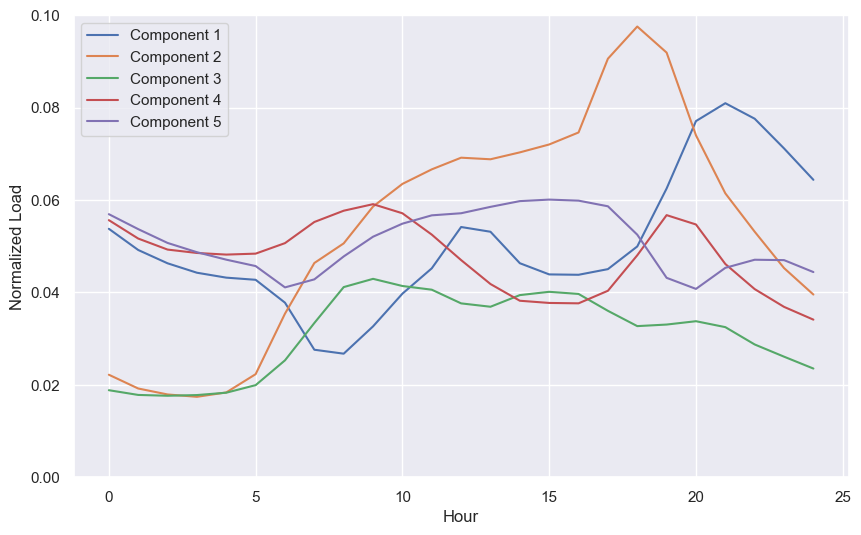

In [95]:
fig, ax = plot_components(H)
plt.ylim((0, 0.1))

In [96]:
day_df.groupby(['daytype'])[[f'Component {k+1}' for k in range(H.shape[0])]].mean()

,Component 1,Component 2,Component 3,Component 4,Component 5
daytype,,,,,
Holiday,160.901353,66.646079,110.314168,136.979123,125.613308
Monday,91.920195,122.952214,603.022375,55.504575,76.069469
Saturday,103.796269,62.830538,183.953751,222.189632,135.391446
Working day,70.702029,100.566906,493.998247,136.509202,139.502171


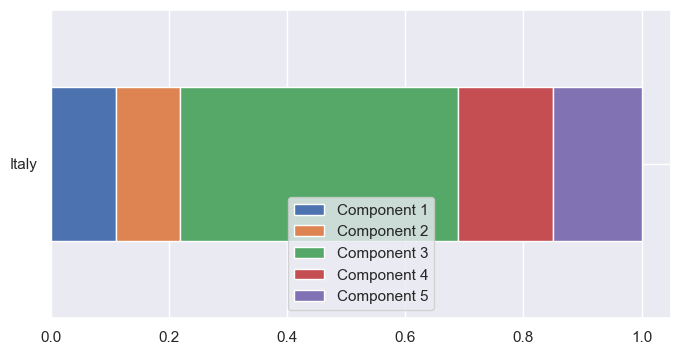

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
df_plot = year_df.groupby('region').sum().drop('year', axis=1)
df_plot = df_plot.div(df_plot.sum(axis=1), axis=0)
df_plot.plot.barh(stacked=True, ax=ax)
ax = ax.set_ylabel("")

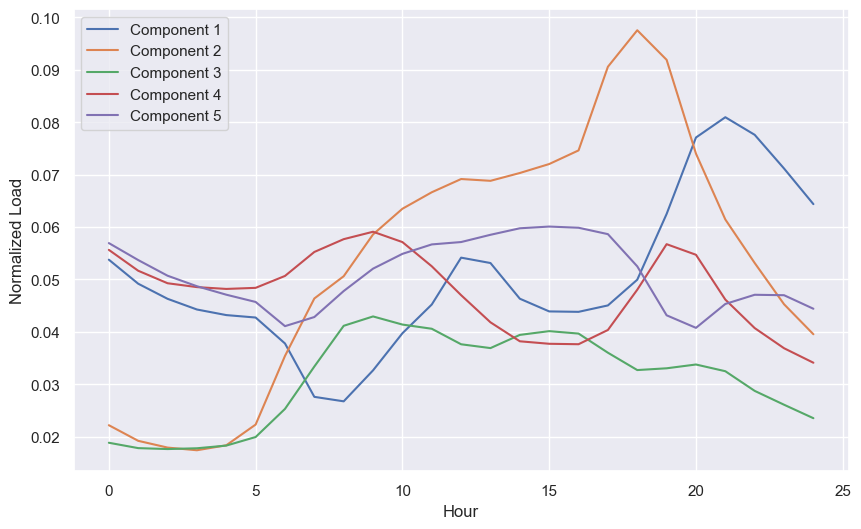

In [98]:
fig, ax = plot_components(H)

In [99]:
year_df.groupby('region').sum().drop('year', axis=1)

,Component 1,Component 2,Component 3,Component 4,Component 5
region,,,,,
Italy,136382.80736,135333.14945,585883.875446,200990.76058,187065.292059


In [100]:
month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)

,year,month,Component 1,Component 2,Component 3,Component 4,Component 5
0,2020,01,1579.941150,5011.672417,11814.989269,6061.807845,2499.577012
1,2020,02,2015.575619,3683.615486,12544.434454,6406.343823,1300.029503
2,2020,03,3757.662973,2936.054374,10309.156713,5392.309061,1118.593589
3,2020,04,4762.096171,1105.906808,8489.321620,3889.051597,1381.931289
4,2020,05,4247.141754,787.016104,12036.290489,3147.672617,3126.095995
5,2020,06,3468.284176,1509.546541,12076.877178,2398.720542,4927.775574
6,2020,07,3653.353091,2437.083230,12951.408862,1970.217116,7469.780165
7,2020,08,4159.274289,2581.198072,8321.302573,2185.831833,7073.045067
8,2020,09,2899.407417,2434.406990,12830.303551,3956.701209,4480.971565
9,2020,10,2511.088361,3038.144379,13557.322453,5902.364672,1651.478539


Add plot of data from the IMSER

In [101]:
imser = pd.read_excel('data/1_input/indicators/IMSER2.xlsx')
imser.head()

,Mese,IMSER (GWh)
0,2019-01-01,6946.499671
1,2019-02-01,6021.581435
2,2019-03-01,6214.210033
3,2019-04-01,5791.996595
4,2019-05-01,6102.287076


In [102]:
imcei = pd.read_excel('data/1_input/indicators/IMCEI_mensile.xlsx')
imcei['Mese'] = pd.to_datetime(imcei['Anno'].astype(str) + '-' + imcei['Mese'], format='%Y-%b')
imcei.head()

,Anno,Mese,IMCEI Mensile
0,2018,2018-01-01,101.876892
1,2018,2018-02-01,104.070890
2,2018,2018-03-01,112.023582
3,2018,2018-04-01,102.915390
4,2018,2018-05-01,113.072924


In [103]:
domestic1 = pd.read_excel('data/1_input/indicators/Domestico 2020 e 2021.xlsx', skiprows=12, usecols=range(3))
domestic2 = pd.read_excel('data/1_input/indicators/Domestico 2022 e 2023.xlsx', skiprows=12, usecols=range(3))
domestic = pd.concat([domestic1, domestic2], ignore_index=True)
domestic.head()

,Mese,Domestico kWh,Domestico GWh
0,2020-01-01,4.741474e+09,4741.474351
1,2020-02-01,4.120931e+09,4120.931091
2,2020-03-01,4.571397e+09,4571.397146
3,2020-04-01,4.056376e+09,4056.375574
4,2020-05-01,3.817226e+09,3817.225967


Correlation between the two series: 0.956


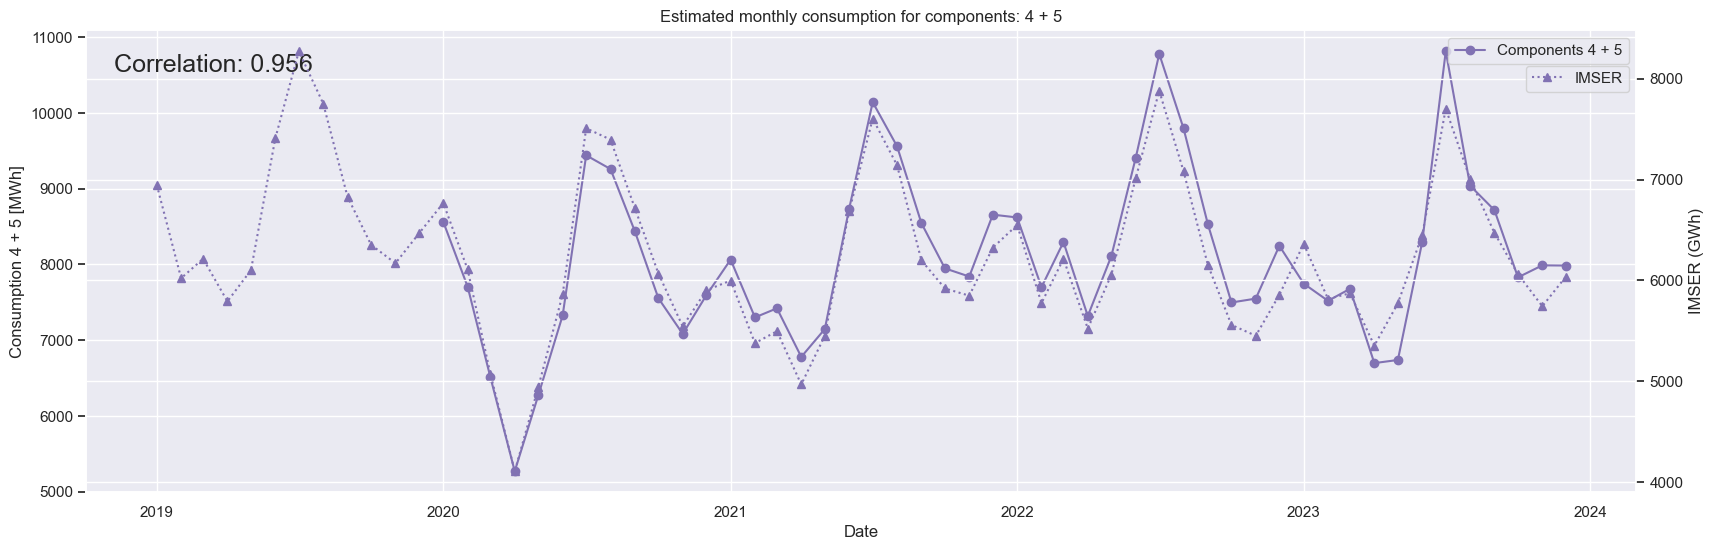

In [104]:
# Convert year and month to datetime
years = train_years + test_years
df_plot = month_df[month_df.year.astype(int).isin(years)].groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)
df_plot['date'] = pd.to_datetime(df_plot['year'].astype(str) + '-' + df_plot['month'], format='%Y-%m')

# Drop year and month columns
df_plot.drop(columns=['year', 'month'], inplace=True)

# Set the 'date' column as the index
df_plot.set_index('date', inplace=True)

# Plotting the first component
plt.figure(figsize=(20, 6))
ax1 = plt.gca()  # get current axes

# Plot the first component on the primary y-axis
comp_to_sum = [4, 5]
est_cons = df_plot[[f'Component {k}' for k in comp_to_sum]].sum(axis=1)
ax1.plot(df_plot.index, est_cons, label='Components {}'.format(' + '.join([str(comp) for comp in comp_to_sum])), marker='o', color=colors[k])
ax1.set_xlabel('Date')
ax1.set_ylabel('Consumption {} [MWh]'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.set_title('Estimated monthly consumption for components: {}'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.legend()
# ax1.set_ylim((0, 1.5e7))

ax2 = ax1.twinx()
ax2.plot(imser.Mese, imser['IMSER (GWh)'], label='IMSER', marker='^', color=colors[k], linestyle='dotted')
ax2.set_ylabel('IMSER (GWh)')
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

corr = est_cons.corr(imser.set_index('Mese')['IMSER (GWh)'])

# Add annotation for correlation coefficient
ax1.annotate('Correlation: {:.3f}'.format(corr), xy=(0.0, 0.85), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset points',  fontsize=18)

print('Correlation between the two series: {:.3f}'.format(corr))

# Show plot
plt.show()

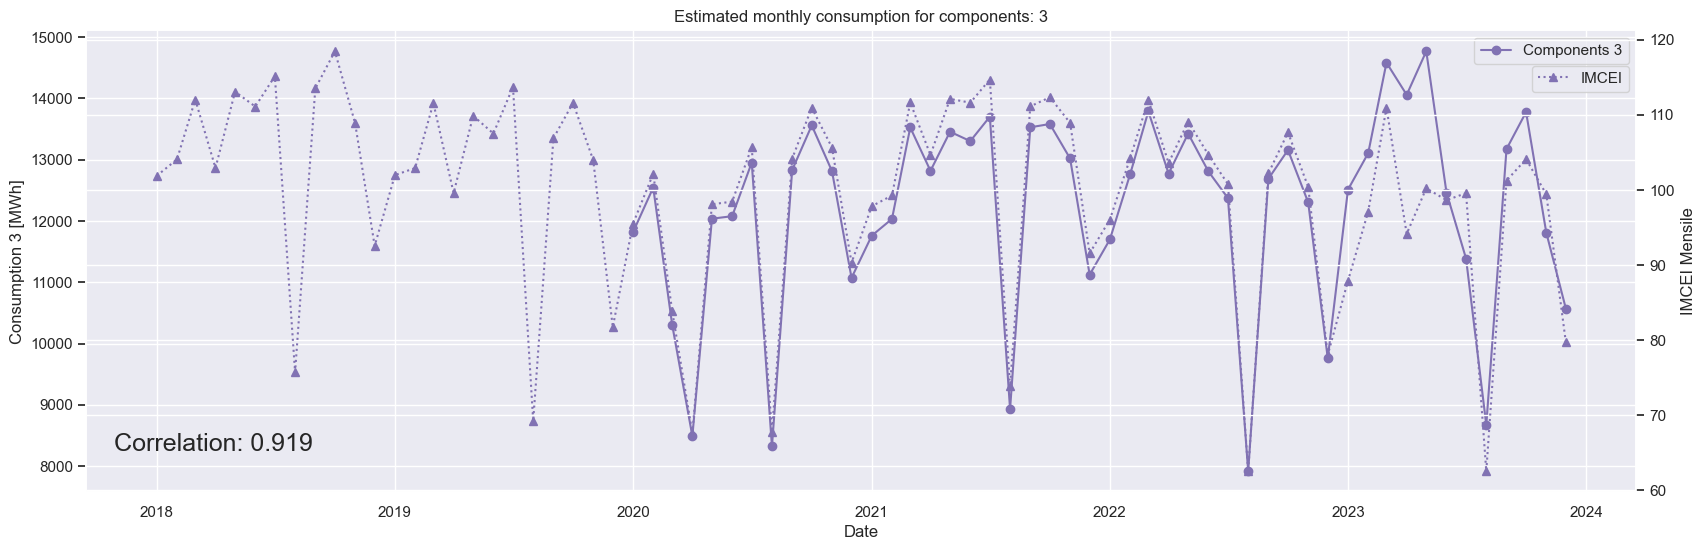

In [105]:
# Plotting the first component
plt.figure(figsize=(20, 6))
ax1 = plt.gca()  # get current axes

# Plot the first component on the primary y-axis
comp_to_sum = [3]
# ax1.plot(df_plot.index, df_plot[col], label=col, marker='o', color=colors[k])
est_cons = df_plot[[f'Component {k}' for k in comp_to_sum]].sum(axis=1)

ax1.plot(df_plot.index, est_cons, label='Components {}'.format(' + '.join([str(comp) for comp in comp_to_sum])), marker='o', color=colors[k])
ax1.set_xlabel('Date')
ax1.set_ylabel('Consumption {} [MWh]'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.set_title('Estimated monthly consumption for components: {}'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.legend()
# ax1.set_ylim((0, 1.5e7))

ax2 = ax1.twinx()
ax2.plot(imcei.Mese, imcei['IMCEI Mensile'], label='IMCEI', marker='^', color=colors[k], linestyle='dotted')
ax2.set_ylabel('IMCEI Mensile')
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

corr = est_cons.corr(imcei.set_index('Mese')['IMCEI Mensile'])

# Add annotation for correlation coefficient
ax1.annotate('Correlation: {:.3f}'.format(corr), xy=(0.0, 0.03), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset points',  fontsize=18)

# Show plot
plt.show()

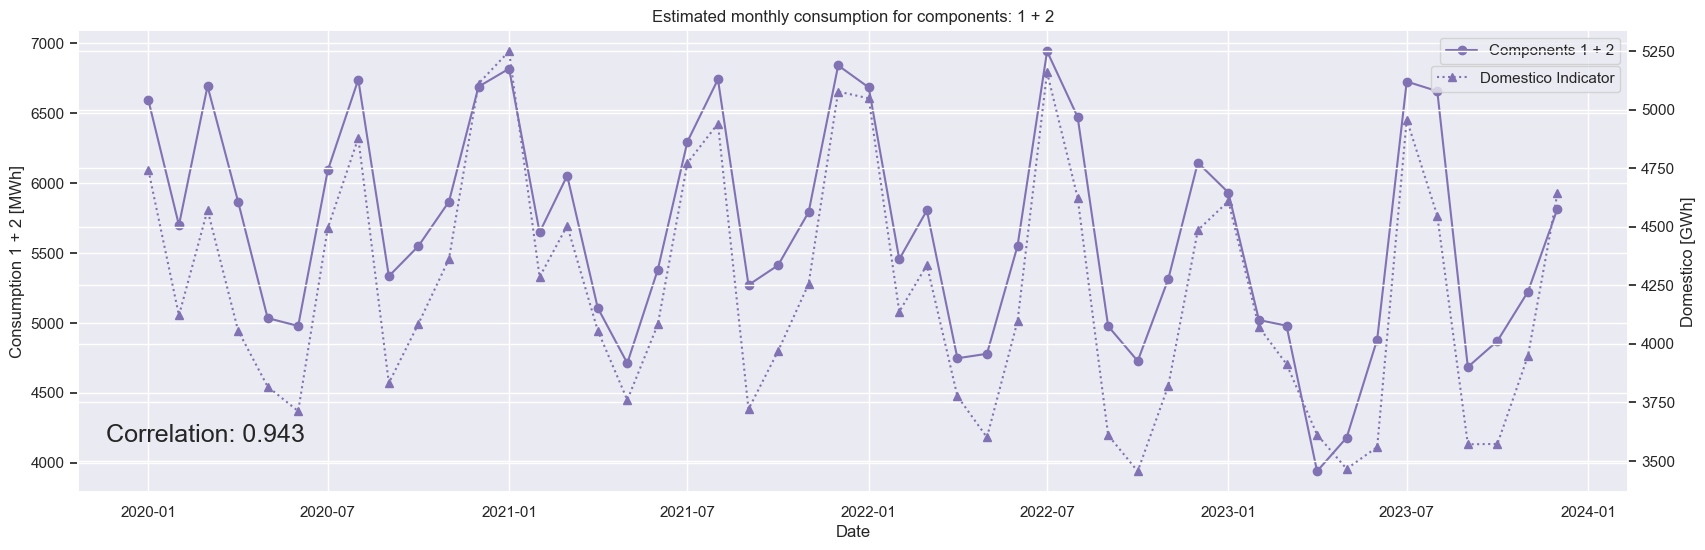

In [106]:
# Plotting the first component
plt.figure(figsize=(20, 6))
ax1 = plt.gca()  # get current axes

# Plot the first component on the primary y-axis
comp_to_sum = [1, 2]
# ax1.plot(df_plot.index, df_plot[col], label=col, marker='o', color=colors[k])
est_cons = df_plot[[f'Component {k}' for k in comp_to_sum]].sum(axis=1)

ax1.plot(df_plot.index, est_cons, label='Components {}'.format(' + '.join([str(comp) for comp in comp_to_sum])), marker='o', color=colors[k])
ax1.set_xlabel('Date')
ax1.set_ylabel('Consumption {} [MWh]'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.set_title('Estimated monthly consumption for components: {}'.format(' + '.join([str(comp) for comp in comp_to_sum])))
ax1.legend()
# ax1.set_ylim((0, 1.5e7))

ax2 = ax1.twinx()
ax2.plot(domestic.Mese, domestic['Domestico GWh'], label='Domestico Indicator', marker='^', color=colors[k], linestyle='dotted')
ax2.set_ylabel('Domestico [GWh]')
ax2.legend(loc='upper right', bbox_to_anchor=(1,0.94))

# corr = df_plot[col].corr(domestic.set_index('Mese')['Domestico GWh'])
corr = est_cons.corr(domestic.set_index('Mese')['Domestico GWh'])

# Add annotation for correlation coefficient
ax1.annotate('Correlation: {:.3f}'.format(corr), xy=(0.0, 0.05), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset points',  fontsize=18)

# Show plot
plt.show()

In [107]:
df_plot = month_df.groupby(['year', 'month'], as_index=False).sum().drop('region', axis=1)
df_plot.head()

,year,month,Component 1,Component 2,Component 3,Component 4,Component 5
0,2020,01,1579.941150,5011.672417,11814.989269,6061.807845,2499.577012
1,2020,02,2015.575619,3683.615486,12544.434454,6406.343823,1300.029503
2,2020,03,3757.662973,2936.054374,10309.156713,5392.309061,1118.593589
3,2020,04,4762.096171,1105.906808,8489.321620,3889.051597,1381.931289
4,2020,05,4247.141754,787.016104,12036.290489,3147.672617,3126.095995


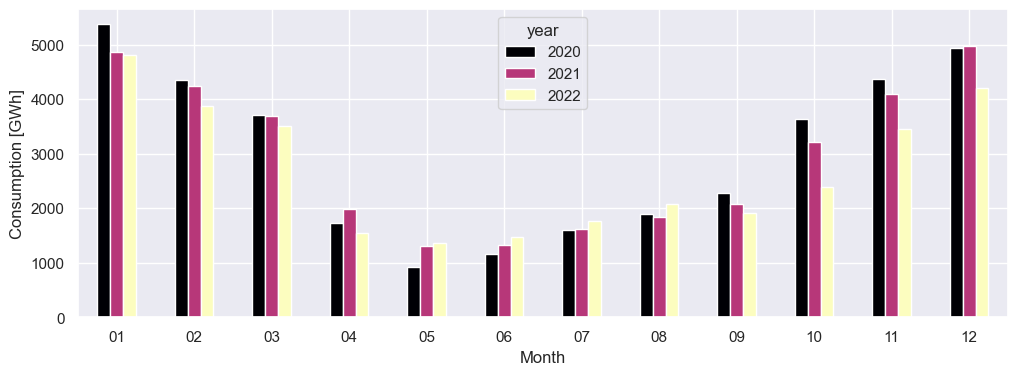

In [156]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 1').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [GWh]')
xlabel = plt.xlabel('Month')

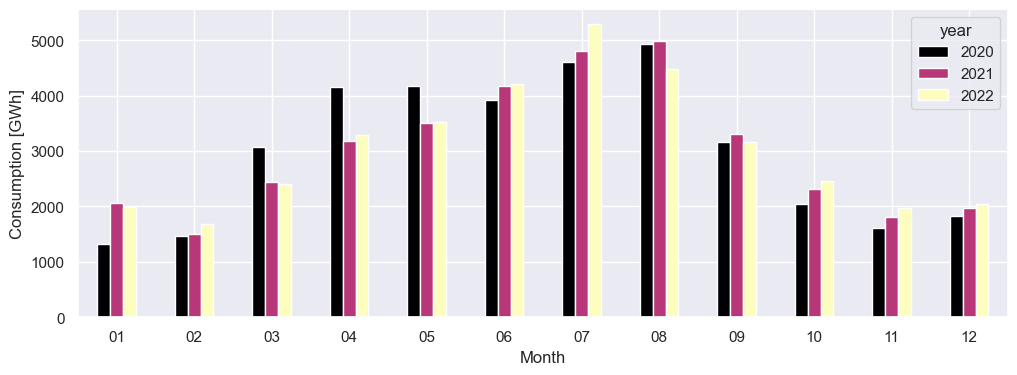

In [158]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 2').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [GWh]')
xlabel = plt.xlabel('Month')

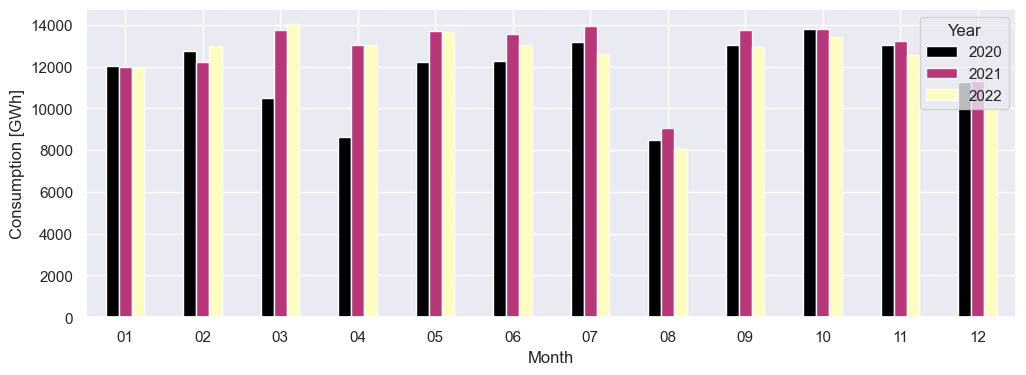

In [159]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 3').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [GWh]')
xlabel = plt.xlabel('Month')
# ylim = plt.ylim((0., 1.3e7))
legend = plt.legend(loc='upper right', title='Year')

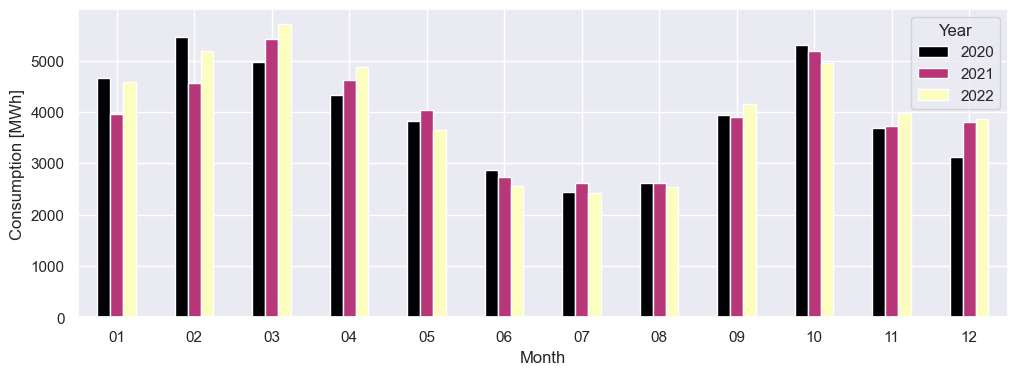

In [160]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 4').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')
# ylim = plt.ylim((0., 1.3e7))
legend = plt.legend(loc='upper right', title='Year')

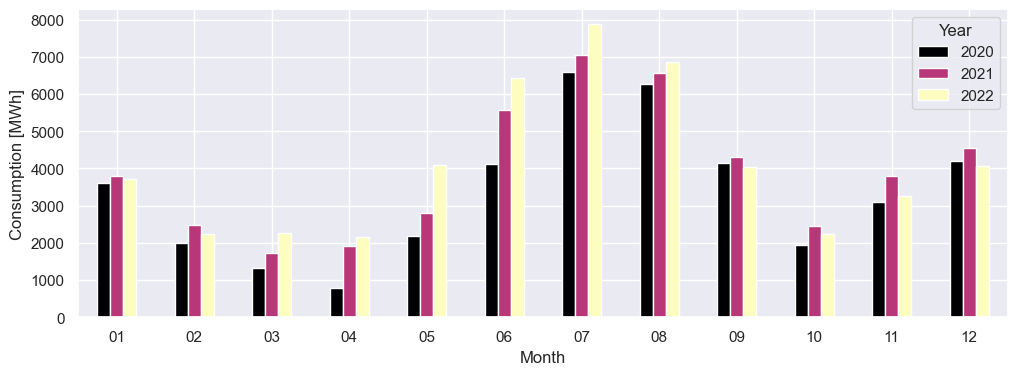

In [161]:
fig, ax = plt.subplots(figsize=(12,4))
df_plot.pivot(columns='year', index='month', values='Component 5').plot.bar(ax=ax, colormap='magma')
ticks = plt.xticks(rotation=0)
ylabel = plt.ylabel('Consumption [MWh]')
xlabel = plt.xlabel('Month')
# ylim = plt.ylim((0., 1.3e7))
legend = plt.legend(loc='upper right', title='Year')

<HR>

# TESTS

In [57]:
norm_X.sum() / 3

311475.1727684037

In [41]:
df.groupby(['region', 'year'], sort=False).size()

region        year
Calabria      2021    365
              2022    365
Centre.North  2018    365
              2019    365
              2020    366
              2021    365
              2022    365
Centre.South  2018    365
              2019    365
              2020    366
              2021    365
              2022    365
North         2018    365
              2019    365
              2020    366
              2021    365
              2022    365
Sardinia      2018    365
              2019    365
              2020    366
              2021    365
              2022    365
Sicily        2018    365
              2019    365
              2020    366
              2021    365
              2022    365
South         2018    365
              2019    365
              2020    366
              2021    365
              2022    365
dtype: int64

In [ ]:
component = 'Component 3'
# region = 'North'

fig = px.bar(
    month_df.groupby(['year', 'month'], as_index=False)[component].sum(),
    x = 'month',
    y = component,
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

NameError: name 'region' is not defined